In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from pytorch_eo.datasets.sen12ms import Sen12MS, Sensor
import albumentations as A 

trans = A.Compose([
	A.Transpose(),
	A.HorizontalFlip(),
	A.VerticalFlip(),
	A.Rotate()
])

ds = Sen12MS(10, path='./data/sen12ms', train_trans=trans, shuffle=False)

ds.setup()

training samples 108398
validation samples 36132
test samples 36132


In [3]:
ds.classes

[{'name': 'other', 'values': [255], 'color': '#000000'},
 {'name': 'dense-forest', 'values': [10], 'color': '#277732'},
 {'name': 'open-forest', 'values': [20, 25], 'color': '#56bf64'},
 {'name': 'herbaceous', 'values': [30, 36, 35], 'color': '#00ff00'},
 {'name': 'shrublands', 'values': [40], 'color': '#ffeb14'},
 {'name': 'urban', 'values': [9], 'color': '#ff0000'},
 {'name': 'permanent-snow-and-ice', 'values': [2], 'color': '#ffffff'},
 {'name': 'barren', 'values': [1], 'color': '#888888'},
 {'name': 'water-bodies', 'values': [3], 'color': '#0000ff'}]

In [6]:
imgs, masks = next(iter(ds.train_dataloader()))

imgs.shape, imgs.dtype, imgs.max(), imgs.min()

(torch.Size([10, 3, 256, 256]), torch.float32, tensor(1.), tensor(0.0586))

In [7]:
masks.shape, masks.dtype, masks.max(), masks.min()

(torch.Size([10, 9, 256, 256]), torch.float32, tensor(1.), tensor(0.))

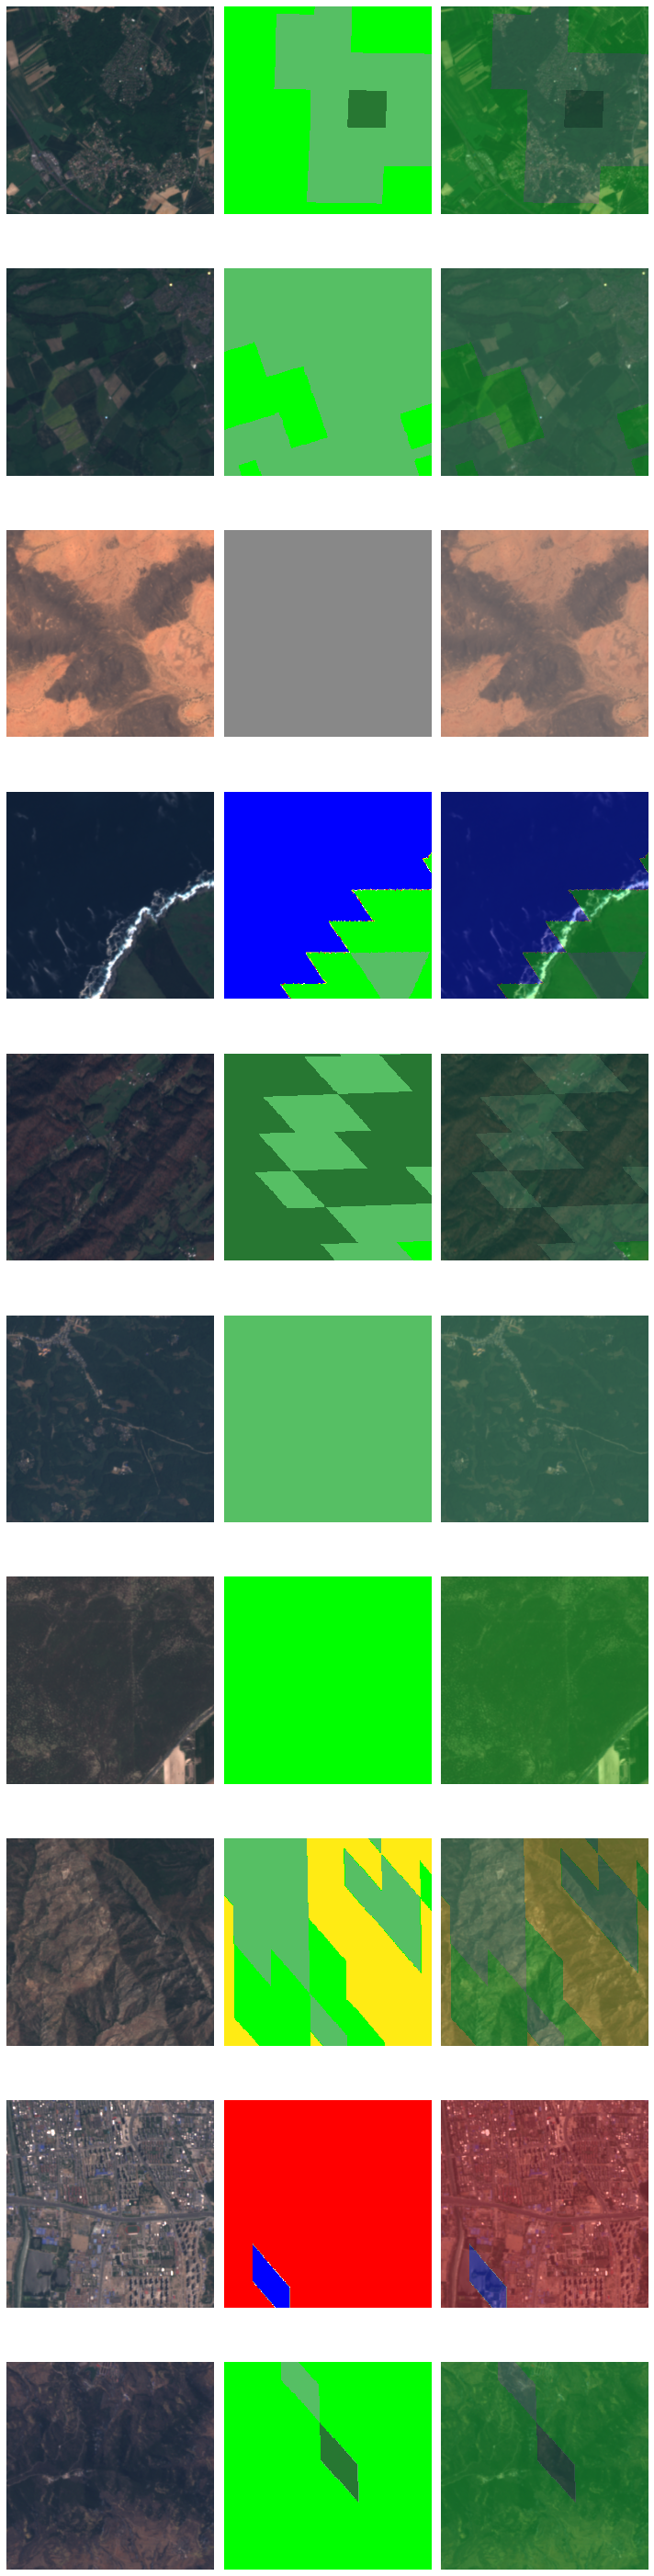

In [8]:
import matplotlib.pyplot as plt
import matplotlib
import torch 
import numpy as np

colors = [label['color'] for label in ds.classes]
cmap = matplotlib.colors.ListedColormap(colors)
boundaries = np.arange(-0.5, len(colors) + 0.5, 1)
norm = matplotlib.colors.BoundaryNorm(boundaries, cmap.N)

imgs, masks = next(iter(ds.train_dataloader()))
fig = plt.figure(figsize=(10, len(imgs)*4))
for i, (img, mask) in enumerate(zip(imgs, masks)):
    
    #img = torch.stack(3*[img[0]]) # vv
    img = img.permute(1,2,0) # rgb

    ax = plt.subplot(len(imgs), 3, 3*i + 1)
    ax.imshow(img) 
    ax.axis('off')
    ax = plt.subplot(len(imgs), 3, 3*i + 2)
    mask = torch.argmax(mask, axis=0)
    ax.imshow(mask, cmap=cmap, norm=norm)
    ax.axis('off')
    ax = plt.subplot(len(imgs), 3, 3*i + 3)
    ax.imshow(img) 
    ax.imshow(mask, cmap=cmap, norm=norm, alpha=0.3)
    #ax.imshow(mask)
    ax.axis('off')
plt.tight_layout()
plt.show()

In [88]:
from pytorch_eo.tasks.segmentation import ImageSegmentation

model = ImageSegmentation(
	model='Unet',
	backbone='resnet18',
	in_chans=ds.in_chans,
	num_classes=ds.num_classes
)

out = model(imgs)

out.shape, out.dtype

(torch.Size([10, 9, 256, 256]), torch.float32)

In [89]:
import pytorch_lightning as pl

ds = Sen12MS(batch_size=256, path='./data/sen12ms')

model = ImageSegmentation(
	model='Unet',
	backbone='resnet18',
	in_chans=ds.in_chans,
	num_classes=ds.num_classes
)

trainer = pl.Trainer(
    gpus=1,
    precision=16,
    max_epochs=3
)

trainer.fit(model, ds)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
Using native 16bit precision.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


training samples 108398
validation samples 36132
test samples 36132



  | Name  | Type | Params
-------------------------------
0 | model | Unet | 14.3 M
-------------------------------
14.3 M    Trainable params
0         Non-trainable params
14.3 M    Total params
57.317    Total estimated model params size (MB)


/home/juan/miniconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/data_loading.py:102: UserWarning: The dataloader, val dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 20 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/home/juan/miniconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/data_loading.py:102: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 20 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


/home/juan/miniconda3/lib/python3.9/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:610: LightningDeprecationWarning: Relying on `self.log('val_loss', ...)` to set the ModelCheckpoint monitor is deprecated in v1.2 and will be removed in v1.4. Please, create your own `mc = ModelCheckpoint(monitor='your_monitor')` and use it as `Trainer(callbacks=[mc])`.
  warning_cache.deprecation(


In [90]:
trainer.test()

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


training samples 108398
validation samples 36132
test samples 36132


/home/juan/miniconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/data_loading.py:102: UserWarning: The dataloader, test dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 20 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(



--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_iou': 0.7658271193504333, 'test_loss': 0.21895644068717957}
--------------------------------------------------------------------------------


[{'test_loss': 0.21895644068717957, 'test_iou': 0.7658271193504333}]

In [97]:
imgs, masks = next(iter(ds.test_dataloader()))

preds = model.predict(imgs)
preds = torch.argmax(preds, axis=1)

preds.shape, preds.dtype, preds.max(), preds.min()

(torch.Size([256, 256, 256]), torch.int64, tensor(8), tensor(1))

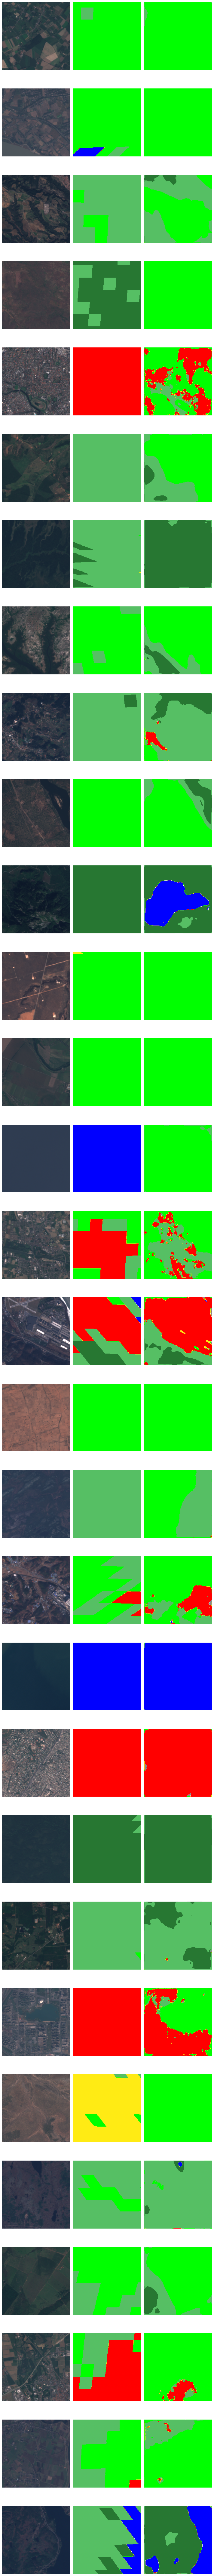

In [99]:
lim = 30
fig = plt.figure(figsize=(10, len(imgs[:lim])*4))
for i, (img, mask, pred) in enumerate(zip(imgs[:lim], masks[:lim], preds[:lim])):
    
    #img = torch.stack(3*[img[0]]) # vv
    img = img.permute(1,2,0) # rgb

    ax = plt.subplot(len(imgs[:lim]), 3, 3*i + 1)
    ax.imshow(img) 
    ax.axis('off')
    ax = plt.subplot(len(imgs[:lim]), 3, 3*i + 2)
    mask = torch.argmax(mask, axis=0)
    ax.imshow(mask, cmap=cmap, norm=norm)
    ax.axis('off')
    ax = plt.subplot(len(imgs[:lim]), 3, 3*i + 3)
    ax.imshow(pred, cmap=cmap, norm=norm)
    ax.axis('off')
plt.tight_layout()
plt.show()